# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd

from datetime import datetime

import pandas as pd
import math


import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline


# Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
from scipy.stats import ks_2samp


# Scaling
from sklearn.preprocessing import  StandardScaler
# PCA
from sklearn.decomposition import PCA

# nice display of tables
from IPython.display import display
from IPython.display import Markdown as md


from sklearn.utils import resample, shuffle

# model selection
from sklearn.model_selection import train_test_split

import lightgbm as lgb


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [4]:
# load in the data#
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=',')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=',')


C:\Users\franz\AppData\Local\Temp\ipykernel_10384\2591506075.py:4: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=',')
C:\Users\franz\AppData\Local\Temp\ipykernel_10384\2591506075.py:5: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=',')


In [2]:

data = pd.read_excel("C:/Users/franz/Documents/udacity/scripts/arvato/DIAS Information Levels - Attributes 2017.xlsx", header = 1)
data2 = pd.read_excel("C:/Users/franz/Documents/udacity/scripts/arvato/DIAS Attributes - Values 2017.xlsx",header =1)
# data = pd.read_excel("./DIAS Information Levels - Attributes 2017.xlsx")
# data2 = pd.read_excel("./DIAS Attributes - Values 2017.xlsx")



In [124]:
print(customers[['LNR'  ,'AGER_TYP']].sort_values("LNR").head(5))
print(azdias[['LNR'  ,'AGER_TYP']].sort_values("LNR").head(5))



        LNR  AGER_TYP
124870  1    2       
124871  2    2       
119293  3    2       
109019  4    2       
109020  5    1       
           LNR  AGER_TYP
694524  191653 -1       
700018  191654 -1       
710905  191655 -1       
736488  191656 -1       
708613  191657  3       


In [125]:
keep_columns = list(set(customers.columns) & set(data.Attribute))
len(keep_columns)


keep_columns_cost = keep_columns+ ['CUSTOMER_GROUP', 'ONLINE_PURCHASE',  'PRODUCT_GROUP']
customers = customers[keep_columns_cost]
azdias = azdias[keep_columns]


In [126]:
print(customers[['CUSTOMER_GROUP', 'ONLINE_PURCHASE',  'PRODUCT_GROUP']].isna().sum())
print(customers[['CUSTOMER_GROUP']].value_counts())
print(customers[['ONLINE_PURCHASE']].value_counts())
print(customers[['PRODUCT_GROUP']].value_counts())

CUSTOMER_GROUP     0
ONLINE_PURCHASE    0
PRODUCT_GROUP      0
dtype: int64
CUSTOMER_GROUP
MULTI_BUYER       132238
SINGLE_BUYER      59414 
dtype: int64
ONLINE_PURCHASE
0                  174356
1                  17296 
dtype: int64
PRODUCT_GROUP    
COSMETIC_AND_FOOD    100860
FOOD                 47382 
COSMETIC             43410 
dtype: int64


In [127]:
#data2_2 = data2.dropna(subset = ["Attribute"])
#data2_2

data2

azdias

KBA13_KW_0_60  KBA05_MOTRAD  D19_VERSI_DATUM  KBA13_HALTER_20  \
0      NaN            NaN            10              NaN                
1       3.0            0.0           10               3.0               
2       1.0            1.0           10               3.0               
3       3.0            3.0           10               2.0               
4       3.0            1.0           2                3.0               
...     ...            ...          ..                ...               
891216  4.0            3.0           10               3.0               
891217  3.0            1.0           10               4.0               
891218  3.0            3.0           9                3.0               
891219  4.0            0.0           10               4.0               
891220  3.0            1.0           10               3.0               

        KBA05_KW3  HEALTH_TYP  NATIONALITAET_KZ  KBA13_TOYOTA  KBA05_KRSKLEIN  \
0      NaN        -1           0                NaN           NaN               
1       4.0        3           1                 2.0           1.0              
2       2.0        3           1                 3.0           3.0              
3       1.0        2           1                 3.0           1.0              
4       3.0        3           1                 3.0           2.0              
...     ...       ..          ..                 ...           ...              
891216  3.0        3           1                 1.0           1.0              
891217  0.0       -1           0                 3.0           1.0              
891218  1.0        1           1                 2.0           1.0              
891219  1.0        1           1                 2.0           2.0              
891220  0.0        2           1                 4.0           3.0              

        KBA13_HALTER_25  ...  KBA05_AUTOQUOT  KBA05_BAUMAX  KBA05_HERST5  \
0      NaN               ... NaN             NaN           NaN             
1       3.0              ...  1.0             5.0           0.0            
2       3.0              ...  3.0             0.0           5.0            
3       2.0              ...  4.0             1.0           3.0            
4       3.0              ...  3.0             0.0           4.0            
...     ...              ...  ...             ...           ...            
891216  3.0              ...  4.0             0.0           2.0            
891217  5.0              ...  1.0             5.0           4.0            
891218  4.0              ...  4.0             0.0           0.0            
891219  3.0              ...  3.0             0.0           1.0            
891220  3.0              ...  2.0             0.0           3.0            

        KBA13_KRSSEG_OBER  SEMIO_KULT  KBA13_FORD  KBA13_SEG_SONSTIGE  \
0      NaN                 3          NaN         NaN                   
1       2.0                3           2.0         2.0                  
2       3.0                3           4.0         2.0                  
3       2.0                4           3.0         2.0                  
4       2.0                6           4.0         5.0                  
...     ...               ..           ...         ...                  
891216  1.0                3           5.0         5.0                  
891217  1.0                4           3.0         4.0                  
891218  3.0                5           3.0         1.0                  
891219  2.0                7           5.0         3.0                  
891220  2.0                6           2.0         4.0                  

        KBA05_KW2  FINANZ_SPARER  SEMIO_PFLICHT  
0      NaN         4              5              
1       3.0        5              7              
2       2.0        4              3              
3       4.0        2              4              
4       2.0        3              4              
...     ...       ..             ..              
891216  2.0       

In [128]:
data.Attribute

0      AGER_TYP            
1      ALTERSKATEGORIE_GROB
2      ANREDE_KZ           
3      CJT_GESAMTTYP       
4      FINANZ_MINIMALIST   
             ...           
308    ARBEIT              
309    EINWOHNER           
310    GKZ                 
311    ORTSGR_KLS9         
312    RELAT_AB            
Name: Attribute, Length: 313, dtype: object

In [129]:
data.Attribute[0:50]

0     AGER_TYP             
1     ALTERSKATEGORIE_GROB 
2     ANREDE_KZ            
3     CJT_GESAMTTYP        
4     FINANZ_MINIMALIST    
5     FINANZ_SPARER        
6     FINANZ_VORSORGER     
7     FINANZ_ANLEGER       
8     FINANZ_UNAUFFAELLIGER
9     FINANZ_HAUSBAUER     
10    FINANZTYP            
11    GEBURTSJAHR          
12    GFK_URLAUBERTYP      
13    GREEN_AVANTGARDE     
14    HEALTH_TYP           
15    LP_LEBENSPHASE_FEIN  
16    LP_LEBENSPHASE_GROB  
17    LP_FAMILIE_FEIN      
18    LP_FAMILIE_GROB      
19    LP_STATUS_FEIN       
20    LP_STATUS_GROB       
21    NATIONALITAET_KZ     
22    PRAEGENDE_JUGENDJAHRE
23    RETOURTYP_BK_S       
24    SEMIO_SOZ            
25    SEMIO_FAM            
26    SEMIO_REL            
27    SEMIO_MAT            
28    SEMIO_VERT           
29    SEMIO_LUST           
30    SEMIO_ERL            
31    SEMIO_KULT           
32    SEMIO_RAT            
33    SEMIO_KRIT           
34    SEMIO_DOM            
35    SEMIO_KAEM    

In [130]:
is_numeric = data2['Meaning'].str.contains('numeric').fillna(False)

numeric_variables = data2[is_numeric]['Attribute']

In [131]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!


In [132]:
print(azdias.head())
print(azdias.info())



   KBA13_KW_0_60  KBA05_MOTRAD  D19_VERSI_DATUM  KBA13_HALTER_20  KBA05_KW3  \
0 NaN            NaN            10              NaN              NaN          
1  3.0            0.0           10               3.0              4.0         
2  1.0            1.0           10               3.0              2.0         
3  3.0            3.0           10               2.0              1.0         
4  3.0            1.0           2                3.0              3.0         

   HEALTH_TYP  NATIONALITAET_KZ  KBA13_TOYOTA  KBA05_KRSKLEIN  \
0 -1           0                NaN           NaN               
1  3           1                 2.0           1.0              
2  3           1                 3.0           3.0              
3  2           1                 3.0           1.0              
4  3           1                 3.0           2.0              

   KBA13_HALTER_25  ...  KBA05_AUTOQUOT  KBA05_BAUMAX  KBA05_HERST5  \
0 NaN               ... NaN             NaN           NaN      

Check which columns are not numeric:

In [133]:
object_columns = azdias.select_dtypes(include=['object'])
print(object_columns.columns)
for column in object_columns.columns:
    print(object_columns[column].value_counts())


Index(['OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype='object')
W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X      373  
Name: CAMEO_DEUG_2015, dtype: int64
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C    9935 
7C    9065 
4B    9047 
4D    8570 
3B    7160 
6A    6810 
9E    6379 
6D    6073 
6F    5392 
7D    5333 
4E    5321 
1E    5065 
7E    4633 
1C    4317 
5F    4283 
1B    4071 
5E    3581 
XX    373  
Name: CAMEO_DEU_2015, dtype: int64


In [134]:
object_columns['CAMEO_DEUG_2015'].value_counts()/len(object_columns)
object_columns['CAMEO_DEUG_2015'] = object_columns['CAMEO_DEUG_2015'].replace('X', -1)
object_columns['CAMEO_DEUG_2015'].fillna(-1,inplace=True)

object_columns['CAMEO_DEUG_2015'].info()#.astype(int)

object_columns['CAMEO_DEUG_2015'] = object_columns['CAMEO_DEUG_2015'].astype(int)

print(object_columns['CAMEO_DEUG_2015'].value_counts()/len(object_columns))



<class 'pandas.core.series.Series'>
RangeIndex: 891221 entries, 0 to 891220
Series name: CAMEO_DEUG_2015
Non-Null Count   Dtype 
--------------   ----- 
891221 non-null  object
dtypes: object(1)
memory usage: 6.8+ MB
 8    0.150850
 9    0.121381
 6    0.118797
 4    0.116595
-1    0.111479
 3    0.097371
 2    0.093390
 7    0.087445
 5    0.062061
 1    0.040632
Name: CAMEO_DEUG_2015, dtype: float64


In [135]:
#check for NAs
print(object_columns['OST_WEST_KZ'].isna().sum())
object_columns['OST_WEST_KZ'].fillna(-1)

object_columns['is_west'] = np.where(object_columns['OST_WEST_KZ'] == 'W', 1, np.where(object_columns['OST_WEST_KZ'] == 'O', 0, -1))
object_columns['is_west'].value_counts()


93148


 1    629528
 0    168545
-1    93148 
Name: is_west, dtype: int64

In [136]:
azdias.describe()

KBA13_KW_0_60   KBA05_MOTRAD  D19_VERSI_DATUM  KBA13_HALTER_20  \
count  785421.000000  757897.000000  891221.000000    785421.000000     
mean   2.977747       1.163318       9.142563         2.909913          
std    0.968180       1.359159       1.911186         1.001968          
min    1.000000       0.000000       1.000000         1.000000          
25%    2.000000       0.000000       9.000000         2.000000          
50%    3.000000       1.000000       10.000000        3.000000          
75%    4.000000       1.000000       10.000000        3.000000          
max    5.000000       9.000000       10.000000        5.000000          

           KBA05_KW3     HEALTH_TYP  NATIONALITAET_KZ   KBA13_TOYOTA  \
count  757897.000000  891221.000000  891221.000000     785421.000000   
mean   1.551242       1.792102       1.026827          3.074966        
std    1.607973       1.269062       0.586634          1.007389        
min    0.000000      -1.000000       0.000000          1.000000        
25%    0.000000       1.000000       1.000000          2.000000        
50%    1.000000       2.000000       1.000000          3.000000        
75%    2.000000       3.000000       1.000000          4.000000        
max    9.000000       3.000000       3.000000          5.000000        

       KBA05_KRSKLEIN  KBA13_HALTER_25  ...  KBA05_AUTOQUOT   KBA05_BAUMAX  \
count  757897.000000   785421.000000    ...  757897.000000   757897.000000   
mean   2.127912        2.945092         ...  3.207994        1.389552        
std    1.159441        1.036591         ...  1.400238        1.779483        
min    1.000000        1.000000         ...  1.000000        0.000000        
25%    2.000000        2.000000         ...  2.000000        0.000000        
50%    2.000000        3.000000         ...  3.000000        1.000000        
75%    2.000000        4.000000         ...  4.000000        3.000000        
max    9.000000        5.000000         ...  9.000000        5.000000        

        KBA05_HERST5  KBA13_KRSSEG_OBER     SEMIO_KULT     KBA13_FORD  \
count  757897.000000  785421.000000      891221.000000  785421.000000   
mean   2.923587       1.954656           4.025014       3.004055        
std    1.539973       0.584313           1.903816       1.040267        
min    0.000000       0.000000           1.000000       1.000000        
25%    2.000000       2.000000           3.000000       2.000000        
50%    3.000000       2.000000           4.000000       3.000000        
75%    4.000000       2.000000           5.000000       4.000000        
max    9.000000       3.000000           7.000000       5.000000        

       KBA13_SEG_SONSTIGE      KBA05_KW2  FINANZ_SPARER  SEMIO_PFLICHT  
count  785421.000000       757897.000000  891221.000000  891221.000000  
mean   3.071439            3.113674       2.821039       4.256076       
std    0.963400            1.333745       1.464749       1.770137       
min    1.000000            1.000000       1.000000       1.000000       
25%    2.000000            2.000000       1.000000       3.000000       
50%    3.000000            3.000000       3.000000       4.000000       
75%    4.000000            4.000000       4.000000       6.000000       
max    5.000000            9.000000       5.000000       7.000000       

[8 rows x 261 columns]

In [137]:
print(customers.head())
print(customers.info())

   KBA13_KW_0_60  KBA05_MOTRAD  D19_VERSI_DATUM  KBA13_HALTER_20  KBA05_KW3  \
0  3.0            1.0           10               1.0              3.0         
1 NaN            NaN            10              NaN              NaN          
2  4.0            1.0           10               3.0              3.0         
3  2.0            1.0           9                4.0              0.0         
4  4.0            0.0           10               2.0              0.0         

   HEALTH_TYP  NATIONALITAET_KZ  KBA13_TOYOTA  KBA05_KRSKLEIN  \
0  1           1                 2.0           2.0              
1  1           1                NaN           NaN               
2  2           1                 3.0           2.0              
3  2           1                 5.0           2.0              
4  3           1                 3.0           1.0              

   KBA13_HALTER_25  ...  KBA13_KRSSEG_OBER  SEMIO_KULT  KBA13_FORD  \
0  1.0              ...  2.0                4           3.0     

In [138]:
customers.describe()

KBA13_KW_0_60   KBA05_MOTRAD  D19_VERSI_DATUM  KBA13_HALTER_20  \
count  140371.000000  135672.000000  191652.000000    140371.000000     
mean   2.767651       1.247280       9.209171         2.770537          
std    0.954970       1.098361       1.856680         0.923539          
min    1.000000       0.000000       1.000000         1.000000          
25%    2.000000       1.000000       10.000000        2.000000          
50%    3.000000       1.000000       10.000000        3.000000          
75%    3.000000       2.000000       10.000000        3.000000          
max    5.000000       9.000000       10.000000        5.000000          

           KBA05_KW3     HEALTH_TYP  NATIONALITAET_KZ   KBA13_TOYOTA  \
count  135672.000000  191652.000000  191652.000000     140371.000000   
mean   1.820693       1.198396       0.773433          3.057426        
std    1.373208       1.450937       0.495983          0.983471        
min    0.000000      -1.000000       0.000000          1.000000        
25%    1.000000      -1.000000       0.000000          2.000000        
50%    2.000000       2.000000       1.000000          3.000000        
75%    3.000000       2.000000       1.000000          4.000000        
max    9.000000       3.000000       3.000000          5.000000        

       KBA05_KRSKLEIN  KBA13_HALTER_25  ...   KBA05_BAUMAX   KBA05_HERST5  \
count  135672.000000   140371.000000    ...  135672.000000  135672.000000   
mean   2.013024        2.615540         ...  1.043826       2.637287        
std    0.835436        0.931909         ...  1.384973       1.281040        
min    1.000000        1.000000         ...  0.000000       0.000000        
25%    2.000000        2.000000         ...  0.000000       2.000000        
50%    2.000000        3.000000         ...  1.000000       3.000000        
75%    2.000000        3.000000         ...  1.000000       3.000000        
max    9.000000        5.000000         ...  5.000000       9.000000        

       KBA13_KRSSEG_OBER     SEMIO_KULT     KBA13_FORD  KBA13_SEG_SONSTIGE  \
count  140371.000000      191652.000000  140371.000000  140371.000000        
mean   2.025198           3.682497       2.856922       2.962093             
std    0.538547           1.573090       1.072144       0.905255             
min    0.000000           1.000000       1.000000       1.000000             
25%    2.000000           3.000000       2.000000       2.000000             
50%    2.000000           4.000000       3.000000       3.000000             
75%    2.000000           5.000000       3.000000       3.000000             
max    3.000000           7.000000       5.000000       5.000000             

           KBA05_KW2  FINANZ_SPARER  SEMIO_PFLICHT  ONLINE_PURCHASE  
count  135672.000000  191652.000000  191652.000000  191652.000000    
mean   3.117489       2.057051       3.528254       0.090247         
std    1.084035       1.319422       1.493916       0.286536         
min    1.000000       1.000000       1.000000       0.000000         
25%    3.000000       1.000000       2.000000       0.000000         
50%    3.000000       1.000000       4.000000       0.000000         
75%    4.000000       4.000000       5.000000       0.000000         
max    9.000000       5.000000       7.000000       1.000000         

[8 rows x 262 columns]

### Now, let's check for missing values:

In [139]:
# Check for missing values in the azdias dataset
missing_azdias = azdias.isna().sum()
print(missing_azdias)

# Check for missing values in the customers dataset
missing_customers = customers.isna().sum()


KBA13_KW_0_60         105800
KBA05_MOTRAD          133324
D19_VERSI_DATUM       0     
KBA13_HALTER_20       105800
KBA05_KW3             133324
                       ...  
KBA13_FORD            105800
KBA13_SEG_SONSTIGE    105800
KBA05_KW2             133324
FINANZ_SPARER         0     
SEMIO_PFLICHT         0     
Length: 264, dtype: int64


Where do we find a lot of missings? And how do we deal with them?

In [140]:
missing_customers_vec = missing_customers[missing_customers>0]/len(customers)
print(missing_customers_vec[missing_customers_vec > 0.3])

customers[missing_customers_vec[missing_customers_vec > 0.3].index].head()

Series([], dtype: float64)


Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]

In [141]:
missing_azdias_vec = missing_azdias[missing_azdias>0]/len(azdias)
missing_azdias_vec[missing_azdias_vec > 0.3]



Series([], dtype: float64)

Now let's start to impute the rest of the columns

In [142]:

#print(missing_customers_vec[missing_customers_vec <= 0.3])
customers[missing_customers_vec[missing_customers_vec <= 0.3].index].head()

KBA13_KW_0_60  KBA05_MOTRAD  KBA13_HALTER_20  KBA05_KW3  KBA13_TOYOTA  \
0  3.0            1.0           1.0              3.0        2.0            
1 NaN            NaN           NaN              NaN        NaN             
2  4.0            1.0           3.0              3.0        3.0            
3  2.0            1.0           4.0              0.0        5.0            
4  4.0            0.0           2.0              0.0        3.0            

   KBA05_KRSKLEIN  KBA13_HALTER_25  ALTER_HH  KBA13_KRSHERST_BMW_BENZ  \
0  2.0             1.0              10.0      3.0                       
1 NaN             NaN               11.0     NaN                        
2  2.0             3.0              6.0       3.0                       
3  2.0             4.0              8.0       5.0                       
4  1.0             2.0              20.0      2.0                       

   CJT_GESAMTTYP  ...  KBA13_HALTER_66  KBA13_KRSSEG_VAN  ANZ_HAUSHALTE_AKTIV  \
0  5.0            ...  3.0              2.0               1.0                   
1 NaN             ... NaN              NaN               NaN                    
2  2.0            ...  4.0              1.0               1.0                   
3  2.0            ...  2.0              3.0               0.0                   
4  6.0            ...  4.0              2.0               7.0                   

   KBA05_AUTOQUOT  KBA05_BAUMAX  KBA05_HERST5  KBA13_KRSSEG_OBER  KBA13_FORD  \
0  5.0             0.0           2.0           2.0                3.0          
1 NaN             NaN           NaN           NaN                NaN           
2  4.0             0.0           3.0           1.0                3.0          
3  3.0             1.0           3.0           3.0                3.0          
4  3.0             0.0           3.0           2.0                4.0          

   KBA13_SEG_SONSTIGE  KBA05_KW2  
0  4.0                 3.0        
1 NaN                 NaN         
2  5.0                 3.0        
3  4.0                 4.0        
4  3.0                 4.0        

[5 rows x 217 columns]

Check if there are rows with many missings:

In [143]:
missing_values_per_row = customers.isna().sum(axis=1)
print(missing_values_per_row[missing_values_per_row/len(customers) > 0.1])
missing_values_per_row = azdias.isna().sum(axis=1)
print(missing_values_per_row[missing_values_per_row/len(azdias) > 0.1])


Series([], dtype: int64)
Series([], dtype: int64)


In [144]:
customers.iloc[0:10]

KBA13_KW_0_60  KBA05_MOTRAD  D19_VERSI_DATUM  KBA13_HALTER_20  KBA05_KW3  \
0  3.0            1.0           10               1.0              3.0         
1 NaN            NaN            10              NaN              NaN          
2  4.0            1.0           10               3.0              3.0         
3  2.0            1.0           9                4.0              0.0         
4  4.0            0.0           10               2.0              0.0         
5  2.0            1.0           10               2.0              4.0         
6  3.0            1.0           10               2.0              1.0         
7  1.0            0.0           10               4.0              2.0         
8  2.0            0.0           10               1.0              0.0         
9  2.0            2.0           10               2.0              3.0         

   HEALTH_TYP  NATIONALITAET_KZ  KBA13_TOYOTA  KBA05_KRSKLEIN  \
0  1           1                 2.0           2.0              
1  1           1                NaN           NaN               
2  2           1                 3.0           2.0              
3  2           1                 5.0           2.0              
4  3           1                 3.0           1.0              
5  3           1                 4.0           2.0              
6  2           1                 3.0           2.0              
7  1           1                 2.0           2.0              
8  2           1                 3.0           2.0              
9  3           1                 2.0           2.0              

   KBA13_HALTER_25  ...  KBA13_KRSSEG_OBER  SEMIO_KULT  KBA13_FORD  \
0  1.0              ...  2.0                4           3.0          
1 NaN               ... NaN                 4          NaN           
2  3.0              ...  1.0                1           3.0          
3  4.0              ...  3.0                4           3.0          
4  2.0              ...  2.0                5           4.0          
5  2.0              ...  1.0                6           2.0          
6  2.0              ...  2.0                4           5.0          
7  3.0              ...  2.0                4           4.0          
8  2.0              ...  2.0                1           1.0          
9  3.0              ...  2.0                5           4.0          

   KBA13_SEG_SONSTIGE  KBA05_KW2  FINANZ_SPARER  SEMIO_PFLICHT  \
0  4.0                 3.0        1              2               
1 NaN                 NaN         1              4               
2  5.0                 3.0        1              4               
3  4.0                 4.0        1              3               
4  3.0                 4.0        1              5               
5  2.0                 2.0        1              3               
6  3.0                 4.0        1              2               
7  3.0                 4.0        1              1               
8  5.0                 1.0        2              1               
9  3.0                 2.0        2              3               

   CUSTOMER_GROUP  ONLINE_PURCHASE      PRODUCT_GROUP  
0  MULTI_BUYER     0                COSMETIC_AND_FOOD  
1  SINGLE_BUYER    0                FOOD               
2  MULTI_BUYER     0                COSMETIC_AND_FOOD  
3  MULTI_BUYER     0                COSMETIC           
4  MULTI_BUYER     0                FOOD               
5  MULTI_BUYER     0                COSMETIC_AND_FOOD  
6  MULTI_BUYER     0                COSMETIC_AND_FOOD  
7  SINGLE_BUYER    0                FOOD               
8  MULTI_BUYER     0                COSMETIC           
9  MULTI_BUYER     0                COSMETIC           

[10 rows x 267 columns]

In [145]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 264 entries, KBA13_KW_0_60 to SEMIO_PFLICHT
dtypes: float64(214), int64(47), object(3)
memory usage: 1.8+ GB


In [3]:
def preprocess_data(df, data):
    """This function ensures the handling of missing values and assigns data types.

    Args:
        df (DataFrame): data to be cleaned
        data (DataFrame): a top-level list of attributes and descriptions

    Returns:
        DataFrame: the cleaned and preprocessed data frame
    """
    # remove all columns with NaN in more than 50% 
    this_filter = df.filter(['ALTER_KIND1','ALTER_KIND2','ALTER_KIND3','ALTER_KIND4','EXTSEL992','KK_KUNDENTYP'])
    df.drop(this_filter, inplace=True, axis=1)
    # remove all columns that are not described in the file.xlsx, because it is not possible to clarify sensibly how to deal with missing values here.  
    
    #data = pd.read_excel("./DIAS Information Levels - Attributes 2017.xlsx")
    keep_columns = set(df.columns) & set(data.Attribute)
    df = df[keep_columns]
    
    ### IMPUTATION ###
    
    # 1.) KBA13 columns
    
    # List of KBA13 columns 
    kba13_columns = [col for col in df.columns if col.startswith('KBA13_') and col != 'KBA13_ANZAHL_PKW']
    # Impute NaNs with -1
    df[kba13_columns] = df[kba13_columns].fillna(-1)
    ## Impute NaNs in 'KBA13_ANZAHL_PKW' with the mean value
    #mean_value = df['KBA13_ANZAHL_PKW'].mean()
    #df['KBA13_ANZAHL_PKW'].fillna(mean_value, inplace=True)

    df[kba13_columns] = df[kba13_columns].astype('category')


    # 2.) KBA05 columns
    # List of KBA05 columns 
    kba05_columns = [col for col in df.columns if col.startswith('KBA05_') and col not in ['KBA05_GBZ', 'KBA05_BAUMAX']]
    df[kba05_columns] = df[kba05_columns].fillna(-1)
    # 9 means the same as -1
    df[kba05_columns] = df[kba05_columns].replace(9, -1)

    kba05_special_treatment = ['KBA05_GBZ', 'KBA05_BAUMAX']
    df[kba05_special_treatment] = df[kba05_special_treatment].fillna(-1)
    # map 0 -> -1 for KBA05_GBZ KBA05_BAUMAX
    df[kba05_special_treatment] = df[kba05_special_treatment].replace(0, -1)

    df[kba05_columns] = df[kba05_columns].astype('category')
    df[kba05_special_treatment] = df[kba05_special_treatment].astype('category')


    # 3.) LP columns
    # List of LP columns 
    # Impute NaNs with -1 : LP_; D19_
    nan_to_minus_1 =[
    'MOBI_REGIO',
    'ONLINE_AFFINITAET',
    'GFK_URLAUBERTYP',
    'OST_WEST_KZ',
    'BALLRAUM',
    'EWDICHTE',
    'INNENSTADT',
    'CAMEO_DEU_2015',
    'CAMEO_DEUG_2015',
    'ORTSGR_KLS9',
    'GEBAEUDETYP_RASTER',
    'WOHNLAGE',
    'KONSUMNAEHE',
    'RELAT_AB'
    ]

    map_0_to_minus_1=[
    'W_KEIT_KIND_HH',
    'KKK',
    'REGIOTYP',
    'HH_EINKOMMEN_SCORE',
    'CJT_GESAMTTYP',
    'RETOURTYP_BK_S',
    'TITEL_KZ',
    'WOHNDAUER_2008',
    'ALTER_HH',
    'GEBAEUDETYP',
    ]

    nan_to_minus_1 = nan_to_minus_1 + map_0_to_minus_1

    lp_columns = [col for col in df.columns if col in nan_to_minus_1 or col.startswith('LP_') or  col.startswith('D19_') or  col.startswith('PLZ8_') ]
    df[lp_columns] = df[lp_columns].fillna(-1)

    df[map_0_to_minus_1] = df[map_0_to_minus_1].replace(0, -1)

    df['RELAT_AB'] = df['RELAT_AB'].replace(9, -1)

    df[lp_columns] = df[lp_columns].astype('category')
    df[map_0_to_minus_1] = df[map_0_to_minus_1].astype('category')
    df['RELAT_AB'] = df['RELAT_AB'].astype('category')


    # 5.) impute numeric columns with mean
    # special treatment for age variables:
    df[['GEBURTSJAHR','MIN_GEBAEUDEJAHR']] = df[['GEBURTSJAHR','MIN_GEBAEUDEJAHR']].fillna(0)
    df[['GEBURTSJAHR','MIN_GEBAEUDEJAHR']] = df[['GEBURTSJAHR','MIN_GEBAEUDEJAHR']].astype(int)


    # now impute other numeric values
    is_numeric = data2['Meaning'].str.contains('numeric').fillna(False)
    numeric_variables = data2[is_numeric]['Attribute']

    df[numeric_variables] = df[numeric_variables].fillna(df[numeric_variables].mean())
    df[numeric_variables] =df[numeric_variables].apply(pd.to_numeric, errors='coerce')

    # 6.) convert all remaining columns to categorical
    numeric_dtypes = set(df.select_dtypes(include='number').columns)
    to_categorical = numeric_dtypes - set(numeric_variables)
    df[list(to_categorical)] = df[list(to_categorical)].astype('category')

    # 7.) special treatment for object columns
    # convert CAMEO_DEUG_2015 in a numeric column 
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', -1)
    df['CAMEO_DEUG_2015'].fillna(-1,inplace=True)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('category')

    # drop, since highly correlated with CAMEO_DEUG_2015
    df.drop('CAMEO_DEU_2015', axis = 1 , inplace=True)

    # convert OST_WEST_KZ into numeric
    df['OST_WEST_KZ'].fillna(-1,inplace=True)
    df['is_west'] = np.where(df['OST_WEST_KZ'] == 'W', 1, np.where(df['OST_WEST_KZ'] == 'O', 0, -1))
    df['is_west'] = df['is_west'].astype('category')
    df.drop("OST_WEST_KZ",axis=1,inplace=True)
    df.drop("ARBEIT",axis=1,inplace=True)
    



    return df


    

In [5]:
customers_cleaned = preprocess_data(customers, data=data)
azdias_cleaned = preprocess_data(azdias, data=data)

    
    

NameError: name 'customers' is not defined

Next, the birth year and the building year are converted to age of the person and building age, respectively.
In addition, the values that are filled with birth or building year 0 are then filled with the mean value. 

In [148]:
#customers[['GEBURTSJAHR','MIN_GEBAEUDEJAHR']]


In [4]:
# 
def replace_with_mean(column, target_value=datetime.now().year):
    """replaces a target value in a column with the mean without considering the target value in calculation of the mean

    Args:
        column (Series): the column where the target value should be replaced
        target_value (_type_, optional): target value, that needs to be replaced. Defaults to datetime.now().year.

    Returns:
        Series: column with imputed values
    """
    if target_value in column.values:
        # Calculate the median without using the target_value
        column_mean = column[column != target_value].mean()
        column = column.replace(target_value, column_mean)
    return column

def get_age_from_year(df, year_columns ,age_columns):
    """calculates the age from the years_columns and drops these columns

    Args:
        df (DataFrame): data frame that needs to be processed
        year_columns (list): list of columns that contain a year which needs to be transformed into age
        age_columns (list): list of columns that contains the calculated age 
    Returns:
        DataFrame: DataFrame with age_columns insted of year_columsn
    """

    assert len(year_columns) == len(age_columns), "Lists must have the same length"
    this_filter = df.filter(year_columns)

    current_year = datetime.now().year
    df[age_columns] = abs(df[year_columns].sub(current_year))  
    df[age_columns] = df[age_columns].apply(replace_with_mean)

    this_filter = df.filter(year_columns)
    df.drop(this_filter, inplace=True, axis=1)

    
    return df




In [150]:
customers_cleaned = get_age_from_year(customers_cleaned, ['GEBURTSJAHR','MIN_GEBAEUDEJAHR'], ['Alter', 'GebAlter'])
azdias_cleaned = get_age_from_year(azdias_cleaned, ['GEBURTSJAHR','MIN_GEBAEUDEJAHR'], ['Alter', 'GebAlter'])

C:\Users\franz\AppData\Local\Temp\ipykernel_8148\1902383369.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[age_columns] = abs(df[year_columns].sub(current_year))
C:\Users\franz\AppData\Local\Temp\ipykernel_8148\1902383369.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[age_columns] = abs(df[year_columns].sub(current_year))
C:\Users\franz\AppData\Local\Temp\ipykernel_8148\1902383369.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [151]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 262 entries, KBA13_KW_0_60 to GebAlter
dtypes: category(255), float64(7)
memory usage: 264.4 MB


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Index(['ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'ANZ_TITEL', 'ANZ_HH_TITEL',
       'ANZ_HAUSHALTE_AKTIV', 'Alter', 'GebAlter'],
      dtype='object')


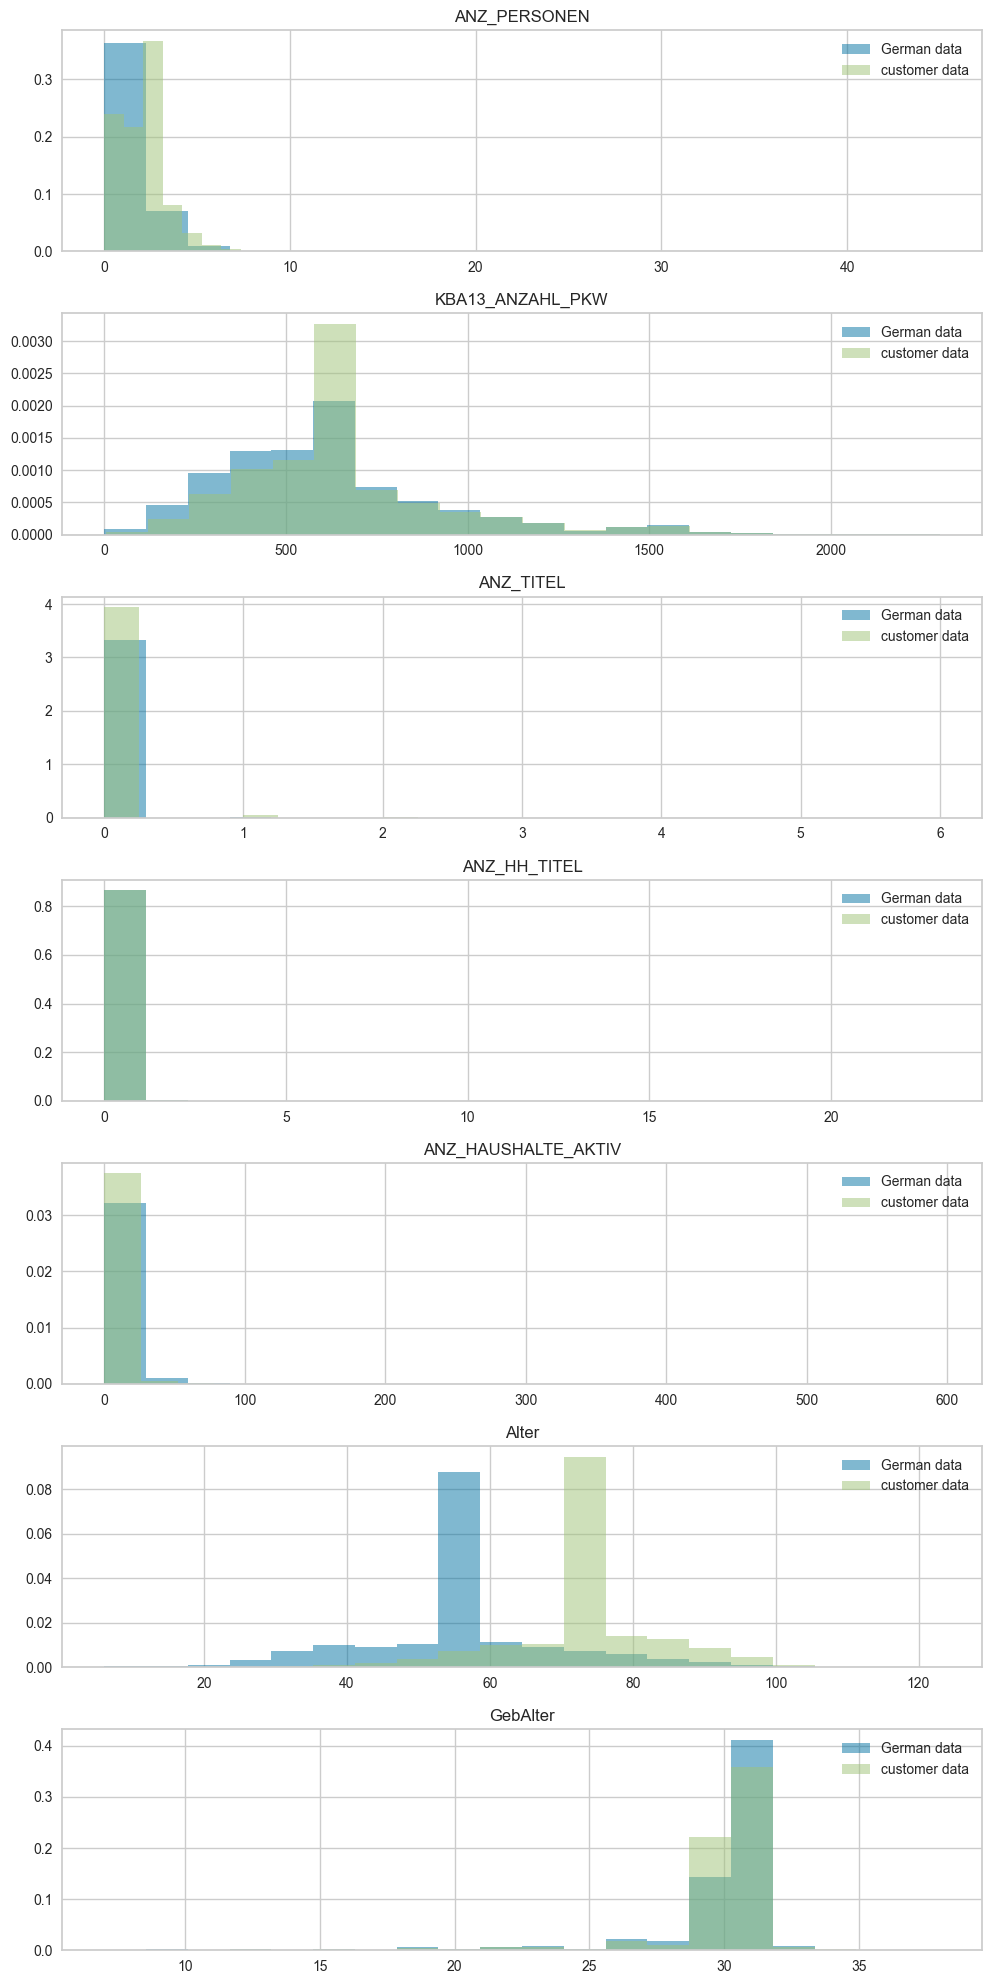

In [152]:
# WIEDER EINKOMMENTIEREN

# Get the list of columns to compare
columns_to_compare = azdias_cleaned.select_dtypes(include='number').columns
num_columns = len(columns_to_compare)


print(columns_to_compare)
# Set up subplots
fig, axes = plt.subplots( num_columns,1, figsize=(10, 20))

# Create histograms for each column in each DataFrame
for i, column in enumerate(columns_to_compare):
    ax = axes[i]
    ax.hist(azdias_cleaned[column], alpha=0.5, density=True, label='German data', bins=20, color='b')
    ax.hist(customers_cleaned[column], alpha=0.5, density=True, label='customer data', bins=20, color='g')
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()


In [153]:
num_columns
columns_to_compare_cat  = list(set(azdias_cleaned.columns) - set(columns_to_compare))
columns_to_compare_cat

columns_to_compare

Index(['ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'ANZ_TITEL', 'ANZ_HH_TITEL',
       'ANZ_HAUSHALTE_AKTIV', 'Alter', 'GebAlter'],
      dtype='object')

In [154]:

columns_to_compare_cat = list(set(azdias_cleaned.columns) - set(columns_to_compare))

print(columns_to_compare_cat )
azdias_cleaned.columns

['D19_VERSI_DATUM', 'KBA13_HALTER_20', 'NATIONALITAET_KZ', 'KBA05_KRSKLEIN', 'KBA13_HALTER_25', 'ALTER_HH', 'D19_GESAMT_ONLINE_DATUM', 'SEMIO_RAT', 'KBA13_KRSHERST_BMW_BENZ', 'CJT_GESAMTTYP', 'KBA13_KW_90', 'KBA13_ALTERHALTER_30', 'KBA05_KRSZUL', 'EWDICHTE', 'KBA13_KMH_110', 'GFK_URLAUBERTYP', 'KBA13_KRSAQUOT', 'KBA13_KRSZUL_NEU', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_DIESEL', 'KBA13_VORB_3', 'KBA13_MERCEDES', 'ONLINE_AFFINITAET', 'SEMIO_FAM', 'KBA13_KW_121', 'D19_VERSI_OFFLINE_DATUM', 'PLZ8_ANTG1', 'KBA13_VW', 'KBA13_KW_40', 'KBA05_MAXAH', 'KBA13_KW_60', 'HH_EINKOMMEN_SCORE', 'KBA05_VORB1', 'KBA13_SITZE_5', 'D19_BANKEN_DATUM', 'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_MINIWAGEN', 'KBA13_KMH_250', 'KBA05_SEG1', 'KBA13_KW_110', 'KBA13_BMW', 'VERS_TYP', 'PLZ8_GBZ', 'KBA13_HALTER_60', 'KBA05_ZUL4', 'D19_TELKO_OFFLINE_DATUM', 'KBA05_HERST2', 'MOBI_REGIO', 'FINANZ_ANLEGER', 'KBA13_SEG_WOHNMOBILE', 'KBA05_VORB2', 'KBA05_MOD3', 'KBA13_CCM_2501', 'KBA13_KW_61_120', 'KBA13_KRSSEG_KLEIN', 'LP_STATUS_

Index(['KBA13_KW_0_60', 'KBA05_MOTRAD', 'D19_VERSI_DATUM', 'KBA13_HALTER_20',
       'KBA05_KW3', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'KBA13_TOYOTA',
       'KBA05_KRSKLEIN', 'KBA13_HALTER_25',
       ...
       'KBA13_KRSSEG_OBER', 'SEMIO_KULT', 'KBA13_FORD', 'KBA13_SEG_SONSTIGE',
       'KBA05_KW2', 'FINANZ_SPARER', 'SEMIO_PFLICHT', 'is_west', 'Alter',
       'GebAlter'],
      dtype='object', length=262)

In [155]:
#customers_cleaned['MIN_GEBAEUDEJAHR']
'MIN_GEBAEUDEJAHR'  in columns_to_compare_cat

False

['D19_VERSI_DATUM', 'KBA13_HALTER_20', 'NATIONALITAET_KZ', 'KBA05_KRSKLEIN', 'KBA13_HALTER_25', 'ALTER_HH', 'D19_GESAMT_ONLINE_DATUM', 'SEMIO_RAT', 'KBA13_KRSHERST_BMW_BENZ', 'CJT_GESAMTTYP', 'KBA13_KW_90', 'KBA13_ALTERHALTER_30', 'KBA05_KRSZUL', 'EWDICHTE', 'KBA13_KMH_110', 'GFK_URLAUBERTYP', 'KBA13_KRSAQUOT', 'KBA13_KRSZUL_NEU', 'D19_VERSAND_ONLINE_QUOTE_12', 'KBA05_DIESEL', 'KBA13_VORB_3', 'KBA13_MERCEDES', 'ONLINE_AFFINITAET', 'SEMIO_FAM', 'KBA13_KW_121', 'D19_VERSI_OFFLINE_DATUM', 'PLZ8_ANTG1', 'KBA13_VW', 'KBA13_KW_40', 'KBA05_MAXAH', 'KBA13_KW_60', 'HH_EINKOMMEN_SCORE', 'KBA05_VORB1', 'KBA13_SITZE_5', 'D19_BANKEN_DATUM', 'KBA13_SEG_MITTELKLASSE', 'KBA13_SEG_MINIWAGEN', 'KBA13_KMH_250', 'KBA05_SEG1', 'KBA13_KW_110', 'KBA13_BMW', 'VERS_TYP', 'PLZ8_GBZ', 'KBA13_HALTER_60', 'KBA05_ZUL4', 'D19_TELKO_OFFLINE_DATUM', 'KBA05_HERST2', 'MOBI_REGIO', 'FINANZ_ANLEGER', 'KBA13_SEG_WOHNMOBILE', 'KBA05_VORB2', 'KBA05_MOD3', 'KBA13_CCM_2501', 'KBA13_KW_61_120', 'KBA13_KRSSEG_KLEIN', 'LP_STATUS_

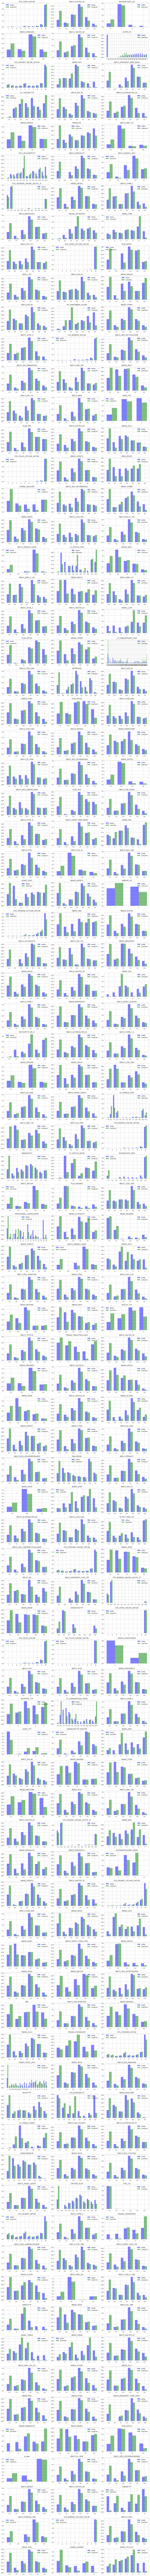

In [156]:

# Get the list of columns to compare
columns_to_compare_cat = list(set(azdias_cleaned.columns) - set(columns_to_compare))

# WIEDER EINKOMMENTIEREN

print(columns_to_compare_cat)
# Set up subplots
num_columns = len(columns_to_compare_cat)
rows = math.ceil(num_columns/3)
fig, axes = plt.subplots(rows, 3, figsize=(15, num_columns))
j=0

# Create bar plot for each column in each DataFrame
for i, column in enumerate(columns_to_compare_cat):
    i_pos = i // 3
    j_pos = i % 3
    ax = axes[i_pos,j_pos]

    # Calculate and sort the frequencies for azdias
    value_counts_azdias = pd.Series(azdias_cleaned[column]).value_counts(normalize=True).sort_index()
    
    # Calculate and sort the frequencies for customers
    value_counts_customers = pd.Series(customers_cleaned[column]).value_counts(normalize=True).sort_index()

    # make sure that the index is the same
    combined_index = value_counts_azdias.index.union(value_counts_customers.index)
    value_counts_azdias = value_counts_azdias.reindex(combined_index, fill_value=0)
    value_counts_customers = value_counts_customers.reindex(combined_index, fill_value=0)


    # Create the bar plots for both DataFrames
    width = 0.35
    x = range(len(value_counts_azdias))
    ax.bar(x, value_counts_azdias, width, label='azdias', color='blue', alpha=0.5)
    ax.bar([i + width for i in x], value_counts_customers, width, label='customers', color='green', alpha=0.5)

    # Set the x-tick labels
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(value_counts_azdias.index)

    ax.set_title(column)
    ax.legend()

plt.subplots_adjust(hspace=0.2, wspace=0.3)  
plt.tight_layout()
plt.show()


In [157]:

# alpha = 0.05  # Set your significance level

# differently_distributed_vars = []

# for column in columns_to_compare:
#     # Apply  KS test to compare the distributions
#     ks_statistic, p_value = ks_2samp(customers[column], azdias[column])

#     # Check if the p-value is less than alpha)
#     if p_value < alpha:
#         differently_distributed_vars.append(column)

# # The list 'differently_distributed_vars' contains the variables with significantly different distributions
# print("Variables with significantly different distributions:", differently_distributed_vars)


In [158]:
azdias_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 262 entries, KBA13_KW_0_60 to GebAlter
dtypes: category(255), float64(7)
memory usage: 264.4 MB


## Reduce Diemnsionality using PCA

Choice of the number of components:

The number of components must be high enough so that the proportion of variance in the data set accounted for by the selected components ("principal components") is still quite high. 
Thus, the loss of information due to the dimensionality reduction triggered by PCA does not become too large.
Here, at least 90% of the variance in the data set should be mapped first.

In [159]:
threshold_variance_explained =0.9

In [160]:
def do_pca(df,n_components=None):
    """performs PCA for a given data frame

    Args:
        df (DataFrame): InputDataFrame
        n_components (int, optional): Number of components to keep. Defaults to None.


    Returns:
        PCA: The PCA result
    """
    
    # # Scale the numerical features
    scaler = StandardScaler()
    numerical_features_scaled = scaler.fit_transform(df)

    # # Merge the preprocessed numerical and categorical features
    preprocessed_data = pd.DataFrame(numerical_features_scaled,columns=df.columns)

    # # Perform PCA on the preprocessed data
    pca = PCA(n_components=n_components)
    reduced_df = pca.fit_transform(preprocessed_data)
    return pca, reduced_df

    

PCA for customers data

In [161]:
customers_cleaned.isna().sum().sort_values(ascending=False)

KBA13_KW_0_60              0
KBA13_HERST_BMW_BENZ       0
SEMIO_REL                  0
D19_KONSUMTYP              0
KBA13_OPEL                 0
                          ..
KBA05_ZUL4                 0
D19_TELKO_OFFLINE_DATUM    0
KBA05_HERST2               0
MOBI_REGIO                 0
GebAlter                   0
Length: 262, dtype: int64

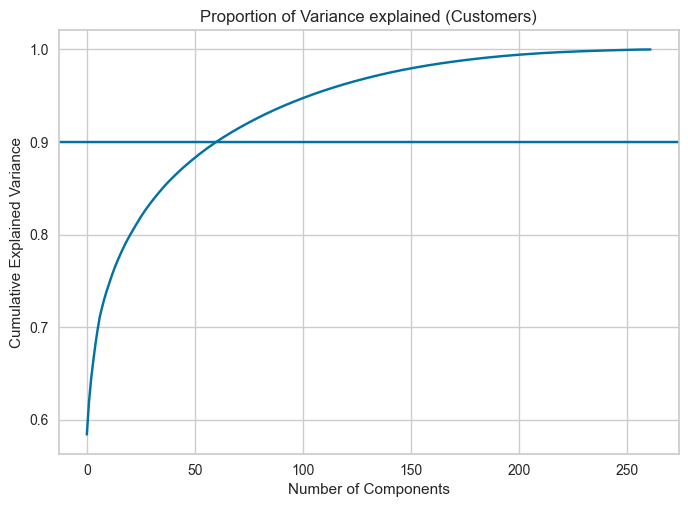

In [162]:
# # Access the principal components and their explained variance ratio

pca, reduced_df_customer = do_pca(customers_cleaned)

principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Proportion of Variance explained (Customers)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=threshold_variance_explained)

plt.show()

expl_var = np.cumsum(pca.explained_variance_ratio_)
sel = list(expl_var < threshold_variance_explained)

last_true_index = None
for i in range(len(sel) - 1, -1, -1):
    if sel[i] == True:
        last_true_index = i
        break

number_components_customer = last_true_index+2





PCA for azdias data

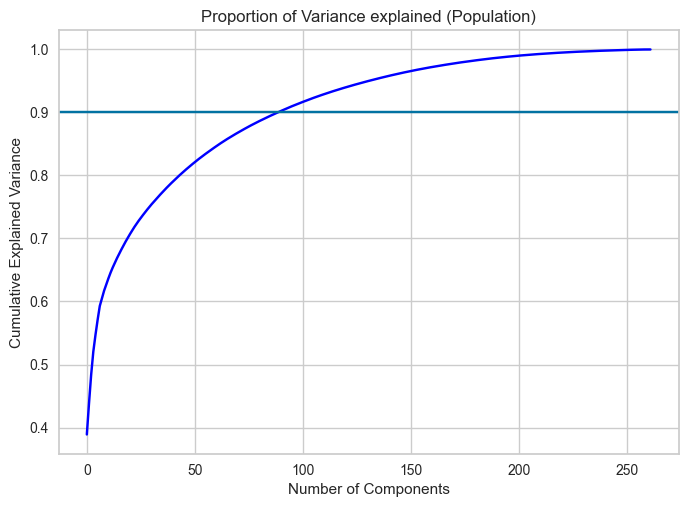

In [163]:

# # Access the principal components and their explained variance ratio

pca, reduced_df_azdias = do_pca(azdias_cleaned)

principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_


plt.plot(np.cumsum(pca.explained_variance_ratio_),color='blue')
plt.title('Proportion of Variance explained (Population)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=threshold_variance_explained)

plt.show()

expl_var = np.cumsum(pca.explained_variance_ratio_)
sel = list(expl_var < threshold_variance_explained)

last_true_index = None
for i in range(len(sel) - 1, -1, -1):
    if sel[i] == True:
        last_true_index = i
        break

number_components_azdias = last_true_index+2


In [164]:
print(number_components_azdias)
print(number_components_customer)

number_components = number_components_azdias#max(number_components_azdias,number_components_customer)

pca_costumers, reduced_df_customer = do_pca(customers_cleaned,n_components=number_components)
pca_azdias, reduced_df_azdias = do_pca(azdias_cleaned,n_components=number_components)

90
61


In [165]:
print('Variance explained by the chosen principal components (azdias):' + str(pca_azdias.explained_variance_ratio_.sum()))
print('Variance explained by the chosen principal components (customer):' + str(pca_costumers.explained_variance_ratio_.sum()))


Variance explained by the chosen principal components (azdias):0.9001309557830476
Variance explained by the chosen principal components (customer):0.9362683235640527


### Variance explained for azdias data

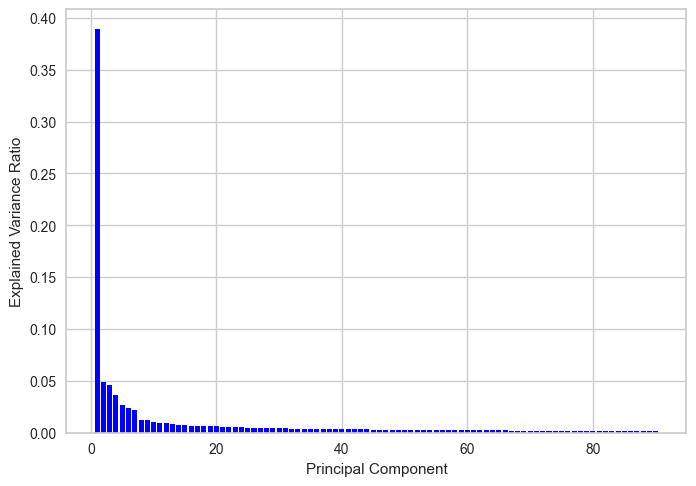

In [166]:

x_values = range(1, len(pca_azdias.explained_variance_ratio_) + 1)  # Adding 1 to start from 1

plt.bar(x_values,pca_azdias.explained_variance_ratio_,color='blue')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.show()

explained_variance_customers = pca_costumers.explained_variance_ratio_


Now I would like to try to describe the individual PCs in more detail. 

### Deep dive into PCA

In [167]:
pd.set_option('display.max_colwidth', -1)

def explain_PC(pca, selected_PC, column_names,n_rows =5):
    """generates insights into Principal components

    Args:
        pca (PCA): the PCA result
        selected_PC (int): PC that should be explained
        n_rows (int, optional): number of positive and negative features to show. Defaults to 5.

    Returns:
        DataFrame: sorted feature loadings and their descriptions
    """
    eigenvectors = pca.components_

    # Feature Weights
    feature_loadings = eigenvectors.T  # Transpose to align with features
    feature_loadings_df = pd.DataFrame(feature_loadings)
    feature_loadings_df.index = column_names
    feature_loadings_df['Attribute'] =  column_names


    feature_loadings_df_info = feature_loadings_df.merge(data[['Attribute',	'Description']	],how="left",on='Attribute')

    # look at seleceted PC: 
    feature_loadings_sorted = feature_loadings_df_info[[selected_PC,'Attribute','Description']].sort_values(by = selected_PC)

    # Top 5 (positive)

    display(feature_loadings_sorted.tail(n_rows))

    # Top 5 (negative)
    display(feature_loadings_sorted.head(n_rows))
    return feature_loadings_sorted


C:\Users\franz\AppData\Local\Temp\ipykernel_8148\788408049.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


NameError: name 'expla' is not defined

In [169]:
# Explore Eigenvectors (Principal Components)
eigenvectors = pca_costumers.components_

# Feature Weights
feature_loadings = eigenvectors.T  # Transpose to align with features
print("Feature Loadings:\n", feature_loadings)

# Feature Importance
feature_importance = np.abs(feature_loadings)
print("Feature Importance:\n", feature_importance)



Feature Loadings:
 [[-0.0719874   0.02127153  0.07619833 ...  0.02420741 -0.00220309
   0.00450273]
 [-0.06257652 -0.03153556 -0.08196189 ... -0.01485243 -0.06440767
  -0.13760251]
 [ 0.01925057  0.10200383 -0.04326036 ... -0.02224509  0.01188025
   0.00529312]
 ...
 [-0.07665806 -0.0037959   0.0184719  ... -0.02743017  0.01656513
   0.05323735]
 [-0.0017099   0.08644865 -0.12093112 ... -0.31888711  0.03754324
  -0.06476983]
 [-0.00951633  0.07110316 -0.20002205 ... -0.10717714  0.10680605
   0.18738932]]
Feature Importance:
 [[0.0719874  0.02127153 0.07619833 ... 0.02420741 0.00220309 0.00450273]
 [0.06257652 0.03153556 0.08196189 ... 0.01485243 0.06440767 0.13760251]
 [0.01925057 0.10200383 0.04326036 ... 0.02224509 0.01188025 0.00529312]
 ...
 [0.07665806 0.0037959  0.0184719  ... 0.02743017 0.01656513 0.05323735]
 [0.0017099  0.08644865 0.12093112 ... 0.31888711 0.03754324 0.06476983]
 [0.00951633 0.07110316 0.20002205 ... 0.10717714 0.10680605 0.18738932]]


#### 1st PC of customer data

In [170]:
sorted_features_cust_0 = explain_PC(pca_costumers,  column_names=customers_cleaned.columns, selected_PC=0)


0              Attribute  \
89   0.051863  SEMIO_KRIT              
166  0.060496  SEMIO_REL               
257  0.065227  FINANZ_SPARER           
96   0.067200  FINANZ_ANLEGER          
10   0.068109  FINANZ_UNAUFFAELLIGER   

                                                       Description  
89   affinity indicating in what way the person is critical minded  
166  affinity indicating in what way the person is religious        
257  financial typology: money saver                                
96   financial typology: investor                                   
10   financial typology: unremarkable

0           Attribute  \
104 -0.078778  KBA13_KRSSEG_KLEIN   
259 -0.076658  is_west              
252 -0.075715  KBA13_KRSSEG_OBER    
87  -0.075550  GEBAEUDETYP_RASTER   
237 -0.075475  WOHNDAUER_2008       

                                                           Description  
104  share of small cars (referred to the county average) - PLZ8        
259  NaN                                                                
252  share of upper class cars (referred to the county average) - PLZ8  
87   industrial areas                                                   
237  length of residenca

In [ ]:
from IPython.display import Markdown as md
md("Explained variance of 1st PC: {}".format(explained_variance_customers[0]))


Explained variance of 1st PC: 0.5839928367019541

People who tend not to think critically, tend not to be religious, show little interest in finances.
People who tend not to drive small cars or high-priced vehicles, more likely to be East Germans, more likely to be in Indusrie areas with low residence time.

It describes the more East German, rather less affluent population in industrial areas. Presumably, single people and couples are also more likely to be represented here, since people with children probably don't change their place of residence that often. 

#### 1st PC of azdias data

In [ ]:

sorted_features_azd_0 = explain_PC(pca_azdias,column_names=azdias_cleaned.columns, selected_PC=0)
md("Explained variance of 1st PC: {}".format(explained_variance_ratio[0]))



0              Attribute  \
188  0.024198  D19_GESAMT_DATUM        
166  0.034433  SEMIO_REL               
89   0.034505  SEMIO_KRIT              
96   0.034962  FINANZ_ANLEGER          
10   0.044067  FINANZ_UNAUFFAELLIGER   

                                                        Description  
188  actuality of the last transaction with the complete file TOTAL  
166  affinity indicating in what way the person is religious         
89   affinity indicating in what way the person is critical minded   
96   financial typology: investor                                    
10   financial typology: unremarkable

0           Attribute  \
104 -0.092779  KBA13_KRSSEG_KLEIN   
252 -0.083845  KBA13_KRSSEG_OBER    
238 -0.083840  KBA13_MOTOR          
246 -0.083205  KBA13_KRSSEG_VAN     
152 -0.081119  PLZ8_HHZ             

                                                           Description  
104  share of small cars (referred to the county average) - PLZ8        
252  share of upper class cars (referred to the county average) - PLZ8  
238  most common motor size within the PLZ8                             
246  share of vans (referred to the county average) - PLZ8              
152  number of households within the PLZ8

Explained variance of 1st PC: 0.38894576143321846




CONCLUSION: The first principal component describes the way individuals think and believe, their financial orientation, and about the vehicles the individuals drive.
 


In [ ]:
sorted_features_azd_1 = explain_PC(pca_azdias,column_names=azdias_cleaned.columns, selected_PC=1)
md("Explained variance of 2nd PC: {}".format(explained_variance_ratio[1]))



1            Attribute                                 Description
79   0.158772  LP_LEBENSPHASE_GROB  lifestage rough                           
124  0.169321  LP_LEBENSPHASE_FEIN  lifestage fine                            
231  0.173297  FINANZ_MINIMALIST    financial typology: low financial interest
235  0.194860  LP_STATUS_GROB       social status rough                       
106  0.196686  LP_STATUS_FEIN       social status fine

1           Attribute  \
69  -0.171395  HH_EINKOMMEN_SCORE   
159 -0.156015  FINANZ_HAUSBAUER     
161 -0.143850  CAMEO_DEUG_2015      
240 -0.143806  PLZ8_BAUMAX          
188 -0.141118  D19_GESAMT_DATUM     

                                                        Description  
69   estimated household_net_income                                  
159  financial typology: main focus is the own house                 
161  CAMEO_4.0: uppergroup                                           
240  most common building-type within the PLZ8                       
188  actuality of the last transaction with the complete file TOTAL

Explained variance of 2nd PC: 0.04901362333978907

Conclusion: The second main component targets the social status of individuals. 

In [ ]:
sorted_features_azd_2 = explain_PC(pca_azdias,column_names=azdias_cleaned.columns, selected_PC=2)
md("Explained variance of 3rd PC: {}".format(explained_variance_ratio[2]))



2                    Attribute  \
141  0.075538  KBA05_HERSTTEMP               
45   0.085958  ONLINE_AFFINITAET             
33   0.085970  D19_VERSAND_ONLINE_QUOTE_12   
118  0.088015  D19_GESAMT_ONLINE_QUOTE_12    
169  0.110091  KBA05_MODTEMP                 

                                                                          Description  
141  Development of the most common car manufacturers in the neighbourhood             
45   online affinity                                                                   
33   amount of online transactions within all transactions in the segment mail-order   
118  amount of online transactions within all transactions in the complete file        
169  Development of the most common car segment in the neighbourhood

2        Attribute  \
261 -0.160962  GebAlter          
20  -0.117848  KBA05_KRSOBER     
145 -0.117613  KBA05_MOTOR       
122 -0.114737  KBA05_KRSHERST1   
214 -0.114168  KBA05_KRSVAN      

                                                    Description  
261  NaN                                                         
20   share of upper class cars (referred to the county average)  
145  most common engine size in the microcell                    
122  share of Mercedes/BMW (reffered to the county average)      
214  share of vans (referred to the county average)

Explained variance of 3rd PC: 0.045680996253415734

Conclusion: The third main component describes the buying behavior and the type of vehicles of the individuals. 

## K Means Clustering

Apply PCA on customers data

In [171]:
reduced_df_customer = pca_azdias.transform(customers_cleaned)

c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

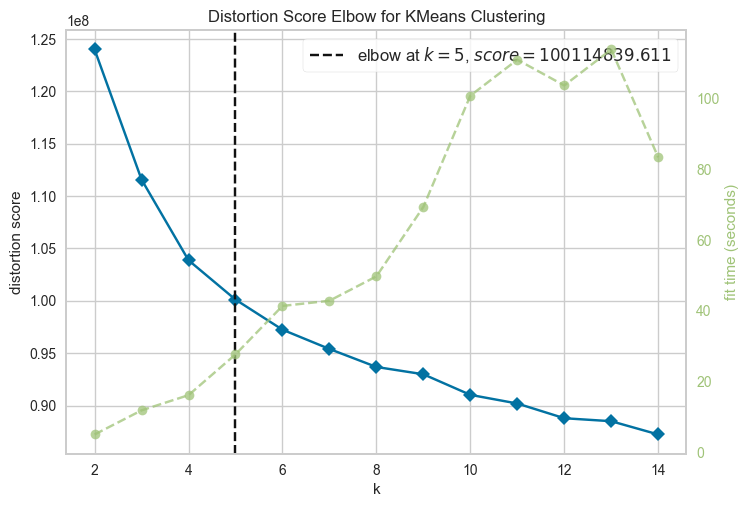

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [172]:
# Elbow Method for K means
# Import ElbowVisualizer
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
# # k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,15), timings= True)
visualizer.fit(reduced_df_azdias)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

In [179]:
n_clusters = visualizer.elbow_value_

md("The optimal number of clusters is {}.".format(n_clusters))




The optimal number of clusters is 5.

Let apply k-means clustering to the azdias data:

In [180]:
kmeans = KMeans(n_clusters=n_clusters)
azdias_clust = kmeans.fit_predict(reduced_df_azdias)


c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [173]:
azdias_clustered = pd.DataFrame(azdias_clust, columns = ['Cluster'])


Let apply k-means clustering to the customers data:

In [181]:
customers_clust = kmeans.predict(reduced_df_customer )
customers_clustered = pd.DataFrame(customers_clust, columns = ['Cluster'])


### Comparison of clusters

Here the cluster from both data sets are compared based on their distribution.

In [182]:
proportions_azdias = pd.Series(azdias_clust).value_counts().sort_index()/len(azdias_clust)
proportions_customer = pd.Series(customers_clust).value_counts().sort_index()/len(customers_clust)

In [183]:
print(proportions_customer)
print(proportions_azdias)

0    0.524351
1    0.000031
2    0.243478
3    0.231973
4    0.000167
dtype: float64
0    0.241529
1    0.054008
2    0.118714
3    0.313109
4    0.272641
dtype: float64


Viszualize the proportions of data in the clusters for the two data sets:

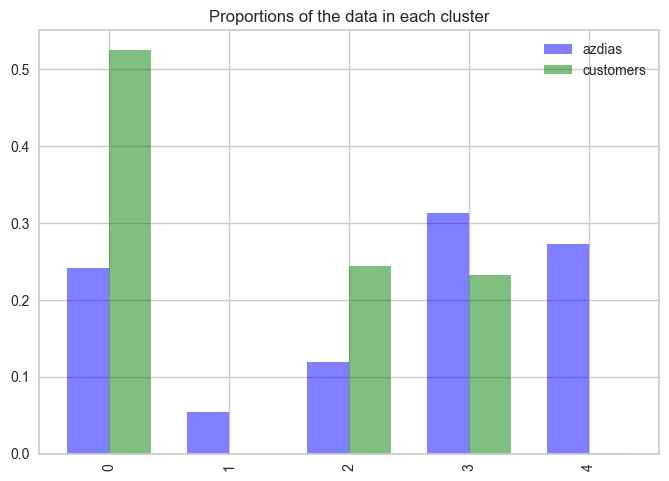

In [184]:
width = 0.35
x = range(len(proportions_azdias))
fig, ax = plt.subplots()

ax.bar(x, proportions_azdias, width, label='azdias', color='blue', alpha=0.5)
ax.bar([i + width for i in x], proportions_customer, width, label='customers', color='green', alpha=0.5)

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(proportions_azdias.index, rotation=90)  # Rotate x-axis labels for better visibility

ax.set_title('Proportions of the data in each cluster')
ax.legend()

plt.show()  

Two clusters have a very different proportion. Here they are described:

In [218]:
def plot_scaled_comparison(df, kmeans, cluster):
    """plot the weights of features for a specific cluster in a k-means clustering model

    Args:
        df (DataFrame): input data
        kmeans : KMeans object
        cluster (int): clster of interest
    """
    centroid = kmeans.cluster_centers_[cluster]
    
    X = pd.DataFrame.from_dict(
        dict(zip(df.columns, pca_costumers.inverse_transform(centroid))),orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][-10:], X['feature_values'][:10]), axis=0).plot(kind='barh', color="green");


Description of cluster 1:

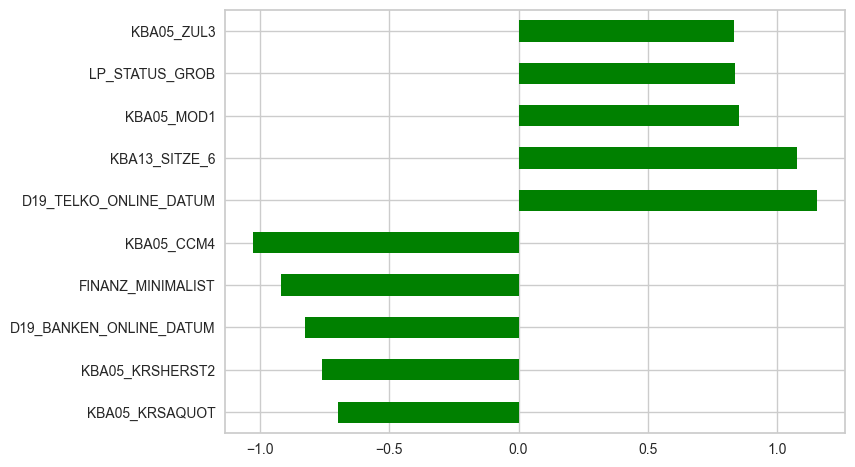

In [186]:
plot_scaled_comparison(customers, kmeans, 0)


Cluster 4


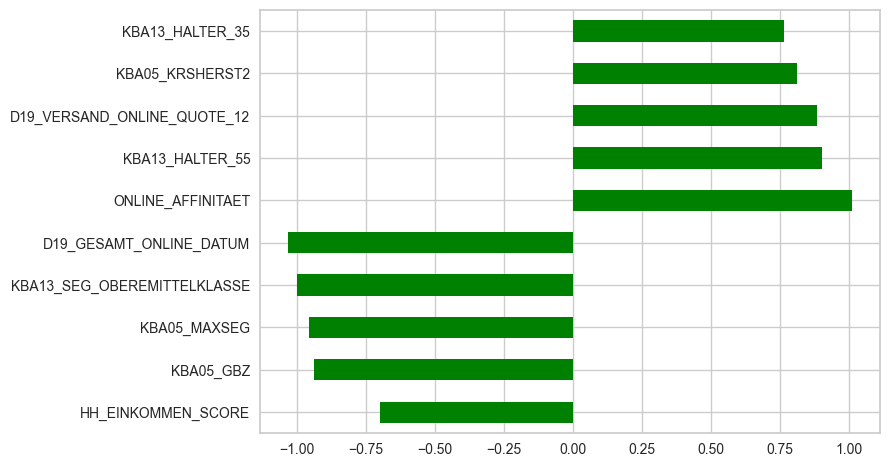

In [188]:
plot_scaled_comparison(customers, kmeans, 4)


Description of cluster 3:

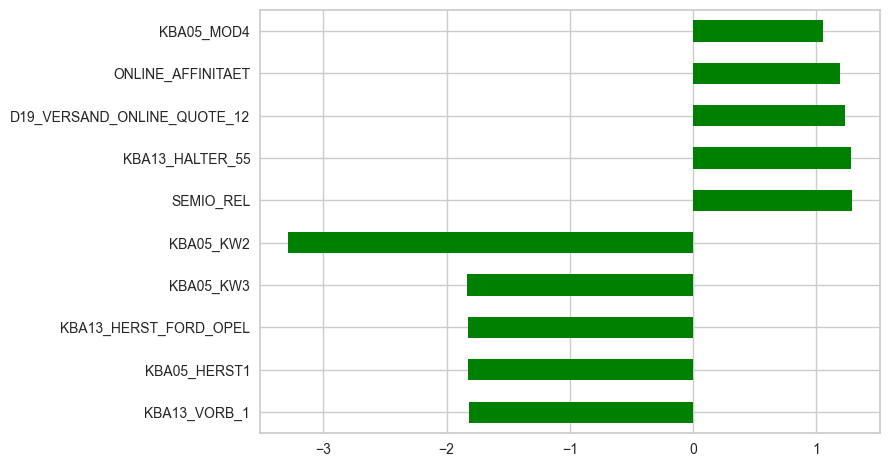

In [187]:
plot_scaled_comparison(customers, kmeans, 1)


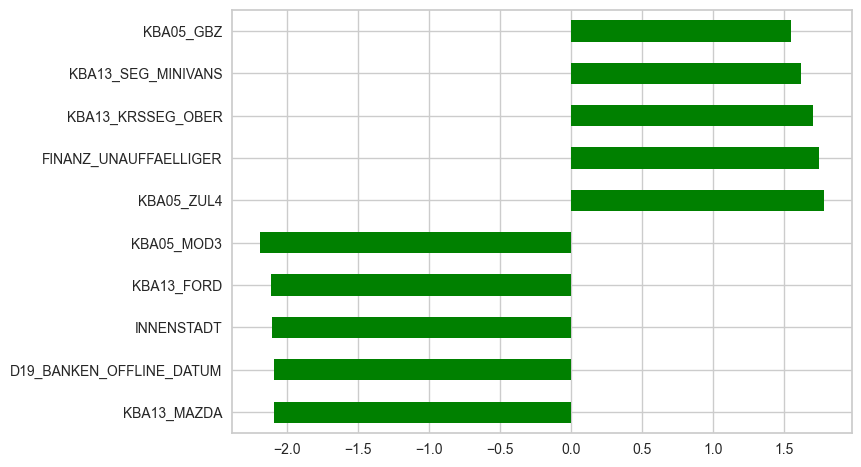

In [189]:
plot_scaled_comparison(customers, kmeans, 2)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [6]:
# EINKOMMENTIEREN
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=',')
mailout_train

# set seed for reproducibility
random_seed = 42
np.random.seed(random_seed)


C:\Users\franz\AppData\Local\Temp\ipykernel_24084\3104493526.py:4: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=',')


In [7]:
mailout_cleaned = preprocess_data(mailout_train, data=data)
mailout_cleaned = get_age_from_year(mailout_cleaned, ['GEBURTSJAHR','MIN_GEBAEUDEJAHR'], ['Alter', 'GebAlter'])


C:\Users\franz\AppData\Local\Temp\ipykernel_24084\1605379696.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df[keep_columns]
C:\Users\franz\AppData\Local\Temp\ipykernel_24084\1605379696.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[kba13_columns] = df[kba13_columns].fillna(-1)
C:\Users\franz\AppData\Local\Temp\ipykernel_24084\1605379696.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[kba13_columns] = df[kba13_c

In [8]:
# final check for missing values
mailout_cleaned.isna().sum().sum()


0

During cleaning appr. 100 columns are lost. However, since there is no infromation about the data available, these columns are dropped. 

In [9]:

print("Number of columns dropped:")
print(len(list(set(mailout_train.columns) - set(mailout_cleaned.columns))))
print("Number of columns in the cleaned train data: ")
print(len(mailout_cleaned.columns))


Number of columns dropped:
103
Number of columns in the cleaned train data: 
262


In [10]:
print(len(mailout_cleaned))
print(len(mailout_train))

mailout_cleaned['RESPONSE'] = mailout_train['RESPONSE']

42962
42962


C:\Users\franz\AppData\Local\Temp\ipykernel_24084\34426420.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mailout_cleaned['RESPONSE'] = mailout_train['RESPONSE']


In [54]:
# mailout_cleaned.drop_duplicates(inplace=True)

C:\Users\franz\AppData\Local\Temp\ipykernel_20036\1275672247.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mailout_cleaned.drop_duplicates(inplace=True)


## The training data is unbalanced

In [11]:
mailout_cleaned['RESPONSE'].value_counts()/len(mailout_cleaned)

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

 To address this issue and build a predictive model for identifying potential customers, there are several strategies:

Resampling techniques like over- and downsampling can be used. 

Further, ensemble techniques like Random Forest, Gradient Boosting, or AdaBoost can handle imbalanced data effectively.
In addition to that overfitting might be a problem when dealing with unbalanced data. Here regularization techniques can help. 

 Instead of using accuracy as  evaluation metric, I will more appropriate metrics for imbalanced datasets, such as precision, recall, F1-score, or the area under the ROC curve (AUC-ROC).


#### Downsampling/Upsampling


In [12]:
#
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def undersample(X,y,target_proportion = 0.3):
    """undersample the data to get a more balanced data set

    Args:
        X (DataFrame): input data independent variable
        y (Series): target variable
        target_proportion (float, optional): TThe proportion of the smallest expression of the target variable to be achieved by undersampling. Defaults to 0.3.

    Returns:
        DataFrame: undersampled data frame
    """

    # Instantiate the RandomUnderSampler 
    undersampler = RandomUnderSampler(sampling_strategy=target_proportion)

    # perform undersampling
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Check the class distribution after undersampling
    print("Class distribution after undersampling:", Counter(y_resampled))

    return X_resampled, y_resampled

#
from imblearn.over_sampling import RandomOverSampler

def oversample(X,y,target_proportion = 0.3):
    """oversample the data to get a more balanced data set

    Args:
        X (DataFrame): input data independent variable
        y (Series): target variable
        target_proportion (float, optional): TThe proportion of the smallest expression of the target variable to be achieved by undersampling. Defaults to 0.3.

    Returns:
        DataFrame: oversampled data frame
    """

    # Instantiate the RandomUnderSampler 

    oversampler = RandomOverSampler(sampling_strategy=target_proportion, random_state=42)

    # perform undersampling
    X_resampled, y_resampled = oversampler.fit_resample(X, y)

    # Check the class distribution after undersampling
    print("Class distribution after undersampling:", Counter(y_resampled))

    return X_resampled, y_resampled

In [17]:
y = mailout_cleaned["RESPONSE"]
X = mailout_cleaned.drop("RESPONSE",axis=1)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.5, random_state=42)



In [18]:

from imblearn.pipeline import Pipeline


resampling_pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy=0.5)),  # Adjust the sampling_strategy as needed
    ('undersampler', RandomUnderSampler(sampling_strategy=0.7)),  # Adjust the sampling_strategy as needed
])


X_train, y_train = resampling_pipeline.fit_resample(X_train_1, y_train_1)
X_test, y_test = resampling_pipeline.fit_resample(X_test_1, y_test_1)



In [15]:
y_train.value_counts()

0    21222
1    14856
Name: RESPONSE, dtype: int64

Compare data befor and after downsampling



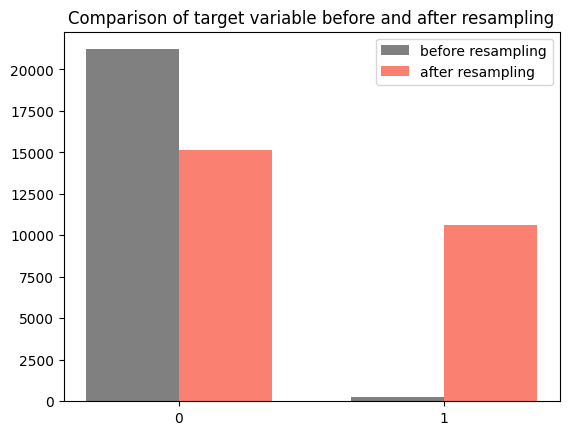

In [19]:
names = ["0","1"]
before =y_train_1.value_counts()
after = y_train.value_counts()

bar_width = 0.35

x = range(len(names))

# Create the barplot
plt.bar(x, before, bar_width, label='before resampling', color="gray")
plt.bar([i + bar_width for i in x], after, bar_width, label='after resampling', color="salmon")

# Set the x-axis labels and title
plt.xticks([i + bar_width/2 for i in x], names)
plt.title('Comparison of target variable before and after resampling')

# Add a legend
plt.legend()

plt.show()

before = mailout_cleaned['RESPONSE'].value_counts()


In [61]:
after

0    13100
1     9170
Name: RESPONSE, dtype: int64

In [20]:


# # # Scale the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)



As mentioned above, I will use cross validation to account for overfitting. The following function performs cross-validation for an arbitrary classifier. 

In [21]:
from sklearn.metrics import make_scorer, precision_recall_curve, auc
from sklearn.model_selection import cross_val_score

def custom_precision_recall_auc(y_true, y_pred):
    """defines a custom precision_recall scorung function

    Args:
        y_true (Series): true values
        y_pred (Series): predictions

    Returns:
        float: area under precision recall curve
    """
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return auc(recall, precision)

# Create a scoring object using make_scorer
custom_scorer = make_scorer(custom_precision_recall_auc, greater_is_better=True)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

def find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid=None, cv=5):
    """finds the optima model based on a given classifier and a param_grid

    Args:
        X_train (DataFrame): training data
        y_train (Series): training response
        X_test (DataFrame): test data
        y_test (Series): test response
        classifier (sklearn classifier): the classifier
        param_grid (Dictionary, optional): te parameter grid. Defaults to None.
        cv (int, optional): croas validation folds. Defaults to 5.

    Returns:
        Tupel: (pr-auc-score for training, pr-auc-score for test, the optimal model)
    """

    if param_grid is not None:
        grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        optimal_model = grid_search.best_estimator_

    else:
        optimal_model = classifier
        optimal_model.fit(X_train,y_train)

    roc_score_train = cross_val_score(optimal_model, X_train, y_train, cv=cv, scoring=custom_scorer).mean()#'roc_auc').mean()
    roc_score_test = cross_val_score(optimal_model, X_test, y_test, cv=cv, scoring=custom_scorer).mean()#'roc_auc').mean()


    return roc_score_train, roc_score_test, optimal_model



In [33]:

y_train.sum()

X_train_1.duplicated().sum()

2914

## Logistic Regression - Benchmark model

In [65]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression( random_state=42)

lg_roc_train, lg_roc_test,lg_model = find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid={})


c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [66]:
# logistic regression l1 regularization

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}


classifier = LogisticRegression(penalty='l2', random_state=42)
lgl1_roc_train, lgl1_roc_test,lgl1_model = find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid=param_grid)


c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\franz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

## SVM

In [67]:
# from sklearn.svm import SVC

# param_grid = {
#     'C': [0.1, 1, 10],  # Regularization parameter (controls trade-off between bias and variance)
#     'kernel': ['linear', 'rbf'],  # Kernel function (linear or radial basis function)
# }

# classifier = SVC(kernel='linear')
# svm_roc_train, svm_roc_test,svm_model = find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid=param_grid)
# svm_roc_test


In [68]:
len(X_train)
len(y_train)

22270

## Random Forest

In [69]:

param_grid =  {
    'n_estimators': [ 100, 200],
    'max_depth': [None, 10, 20]
}
classifier = RandomForestClassifier()

rf_roc_train, rf_roc_test,rf_model = find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid=param_grid)



In [70]:
rf_roc_train

0.9995644478561477

## Gradient Boosted Trees

In [71]:


param_grid = {
    'num_leaves': [16, 32],        # Maximum number of leaves in one tree
    'learning_rate': [0.01, 0.1, 0.2], # Learning rate
    'n_estimators': [100, 200, 300],    # Number of boosting iterations
}

# Create the LightGBM classifier
classifier = lgb.LGBMClassifier()

lgbm_roc_train, lgbm_roc_test,lgbm_model = find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid=param_grid)



In [72]:
print(lg_roc_train)
print(rf_roc_train)
print(lgbm_roc_train)

print(lg_roc_test)
print(rf_roc_test)
print(lgbm_roc_test)


0.7595834406477725
0.9995644478561477
0.9995099521370238
0.7713510188375723
0.999618825299789
0.9995102186283829


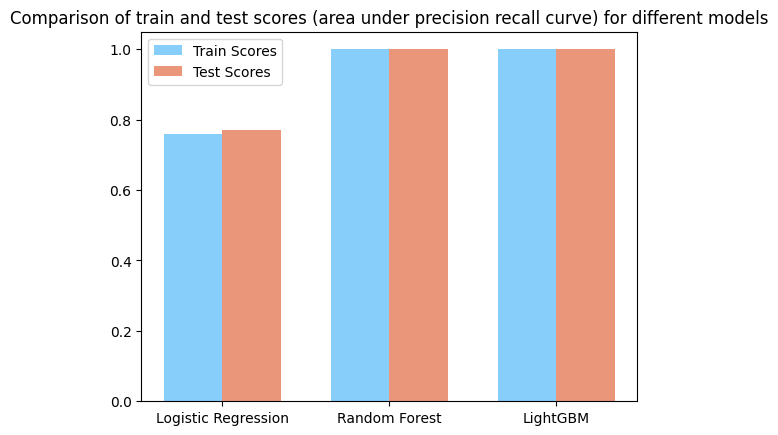

In [73]:
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM']
train_scores = [lg_roc_train, rf_roc_train, lgbm_roc_train]  
test_scores = [lg_roc_test, rf_roc_test, lgbm_roc_test]    

bar_width = 0.35

x = range(len(model_names))

# Create the barplot
plt.bar(x, train_scores, bar_width, label='Train Scores',color = "lightskyblue")
plt.bar([i + bar_width for i in x], test_scores, bar_width, label='Test Scores',color="darksalmon")

# Set the x-axis labels and title
plt.xticks([i + bar_width/2 for i in x], model_names)
plt.title('Comparison of train and test scores (area under precision recall curve) for different models')

# Add a legend
plt.legend()

# Show the plot
plt.show()



BI decide to use the Lightgbm since it performs best on the test set. 


### Fine tune the final model

In [34]:
param_grid = {
    'boosting_type': ['gbdt', 'dart'],  # Different boosting types
    'num_leaves': [8,16, 32],        # Maximum number of leaves in one tree
    'learning_rate': [0.01,0.05, 0.1, 0.2], # Learning rate
    'n_estimators': [100, 200, 300,500, 1000],    # Number of boosting iterations
}

# Create the LightGBM classifier
classifier = lgb.LGBMClassifier()

final_roc_train, final_roc_test,final_model = find_optimal_model(X_train, y_train,X_test, y_test, classifier, param_grid=param_grid)


NameError: name 'lgb' is not defined

In [ ]:
y_pred = final_model.predict(X_test)




In [ ]:
final_roc_test
from sklearn.metrics import make_scorer, balanced_accuracy_score


bal_acc_test = cross_val_score(final_model, X_test, y_test, cv=5, scoring=make_scorer(balanced_accuracy_score))


In [ ]:
print("The final balanced accuracy: ")
print(bal_acc_test.mean())
print("The final area under precision recall curve: ")
print(final_roc_test)

The final balanced accuracy: 
0.9542412652355662
The final area under precision recall curve: 
0.9628646607523162


In [ ]:
mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=',')
mailout_test_cleaned  = preprocess_data(mailout_test, data=data)


C:\Users\franz\AppData\Local\Temp\ipykernel_20036\555827834.py:1: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('./Udacity_MAILOUT_052018_TEST.csv', sep=',')
C:\Users\franz\AppData\Local\Temp\ipykernel_20036\1605379696.py:18: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df = df[keep_columns]
C:\Users\franz\AppData\Local\Temp\ipykernel_20036\1605379696.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[kba13_columns] = df[kba13_columns].fillna(-1)
C:\Users\franz\AppData\Local\Temp\ipykernel_20036\1605379696.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [ ]:
mailout_test_cleaned.isna().sum().sum()

0

In [ ]:
y_test_final = final_model.predict(mailout_test_cleaned)

In [ ]:
y_test_final.sum()
final_model

LGBMClassifier(learning_rate=0.2, n_estimators=1000, num_leaves=16)

In [ ]:
import pkg_resources

# List all installed packages and their versions
installed_packages = pkg_resources.working_set
for package in installed_packages:
    print(f"{package.key}=={package.version}")

pywin32==305
pyzmq==25.0.0
packaging==23.0
ipython==8.8.0
jupyter-client==7.4.9
ipykernel==6.20.2
tornado==6.2
psutil==5.9.4
traitlets==5.8.1
jupyter-core==5.1.4
decorator==5.1.1
prompt-toolkit==3.0.36
pygments==2.14.0
python-dateutil==2.8.2
platformdirs==2.6.2
asttokens==2.2.1
six==1.16.0
debugpy==1.6.6
nest-asyncio==1.5.6
executing==1.2.0
jedi==0.18.2
parso==0.8.3
pickleshare==0.7.5
stack-data==0.6.2
colorama==0.4.6
entrypoints==0.4
wcwidth==0.2.6
pure-eval==0.2.2
backcall==0.2.0
matplotlib-inline==0.1.6
comm==0.1.2
regex==2023.8.8
certifi==2023.7.22
pytz==2022.7.1
setuptools==65.5.0
pip==23.3.1
attrs==23.1.0
pillow==10.0.0
tenacity==8.2.3
click==8.1.6
plotly==5.16.1
tqdm==4.66.1
fonttools==4.42.0
typing-extensions==4.7.1
nltk==3.8.1
matplotlib==3.7.2
pyproj==3.6.0
idna==3.4
lightgbm==3.3.5
charset-normalizer==3.2.0
jinja2==3.1.2
openpyxl==3.1.2
threadpoolctl==3.1.0
pyparsing==3.0.9
requests==2.31.0
werkzeug==2.3.7
flask==2.3.3
markupsafe==2.1.3
itsdangerous==2.1.2
urllib3==2.0.4
gre